In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
items_df = pd.read_csv('./items.csv')
ratings_df = pd.read_csv('./ratings.csv')
users_df = pd.read_csv('./users.csv')
n_items = len(items_df)
n_users = len(users_df)

In [3]:
ratings_matrix = ratings_df.to_numpy()

def get_items_rated_by_user(rate_matrix, user_id):
    user_row_indices = np.where(rate_matrix[:, 0] == user_id + 1)[0]
    if len(user_row_indices) == 0:
        return np.array([]), np.array([])  

    item_ids = rate_matrix[user_row_indices, 1] - 1  
    scores = rate_matrix[user_row_indices, 2]
    return item_ids.astype(int), scores  

In [4]:
# Tải lại các ma trận
Yhat_SVD = np.load('Yhat_SVD.npy')
Yhat_CB = np.load('Yhat_CB.npy')
Yhat_IB = np.load('Yhat_IB.npy')
Yhat_UB = np.load('Yhat_UB.npy')

# In thử thông tin từng ma trận
print("Kích thước ma trận Yhat_SVD:", Yhat_SVD.shape)
print("Kích thước ma trận Yhat_CB:", Yhat_CB.shape)
print("Kích thước ma trận Yhat_IB:", Yhat_IB.shape)
print("Kích thước ma trận Yhat_UB:", Yhat_UB.shape)

Kích thước ma trận Yhat_SVD: (3642, 4312)
Kích thước ma trận Yhat_CB: (3642, 4312)
Kích thước ma trận Yhat_IB: (3642, 4312)
Kích thước ma trận Yhat_UB: (3642, 4312)


In [5]:
# Danh sách các ma trận dự đoán và tên file lưu
prediction_matrices = [
    ("Yhat_SVD", Yhat_SVD),
    ("Yhat_CB", Yhat_CB),
    ("Yhat_IB", Yhat_IB),
    ("Yhat_UB", Yhat_UB),
]

# Hàm xử lý và lưu kết quả
def generate_recommendations(prediction_matrix, file_name):
    all_user_recommendations = []

    # Duyệt qua tất cả người dùng trong tập dữ liệu
    for user_id in range(n_users):
        # Lấy điểm đánh giá dự đoán cho người dùng hiện tại
        user_ratings_pred = prediction_matrix[:, user_id]
        
        # Lấy các sản phẩm mà người dùng đã đánh giá
        rated_items, _ = get_items_rated_by_user(ratings_matrix, user_id)
        
        # Lọc ra các sản phẩm chưa được đánh giá
        unrated_items = [i for i in range(n_items) if i not in rated_items]
        
        # Lấy điểm đánh giá dự đoán cho các sản phẩm chưa được đánh giá
        unrated_item_scores = user_ratings_pred[unrated_items]
        
        # Sắp xếp các sản phẩm chưa đánh giá theo điểm dự đoán giảm dần
        top_10_unrated_items = np.argsort(unrated_item_scores)[::-1][:10]
        
        # Lấy thông tin của các sản phẩm top 10 và điểm dự đoán
        top_10_items = items_df.iloc[top_10_unrated_items].copy()
        top_10_items['PredictedRating'] = unrated_item_scores[top_10_unrated_items]
        
        # Gắn thêm cột ID người dùng, tăng 1 để bắt đầu từ 1
        top_10_items['UserID'] = user_id + 1
        
        # Lưu kết quả vào danh sách tổng
        all_user_recommendations.append(top_10_items[['UserID', 'stockCodeTransform', 'PredictedRating']])
    
    # Gộp tất cả kết quả thành một DataFrame
    all_recommendations_df = pd.concat(all_user_recommendations, ignore_index=True)

    # Lưu vào file CSV
    all_recommendations_df.to_csv(file_name, index=False)
    print(f"Kết quả đã lưu vào file: {file_name}")

# Thực hiện cho từng ma trận dự đoán
for matrix_name, matrix in prediction_matrices:
    output_file = f"recommendations_{matrix_name}.csv"
    generate_recommendations(matrix, output_file)


Kết quả đã lưu vào file: recommendations_Yhat_SVD.csv
Kết quả đã lưu vào file: recommendations_Yhat_CB.csv
Kết quả đã lưu vào file: recommendations_Yhat_IB.csv
Kết quả đã lưu vào file: recommendations_Yhat_UB.csv


In [6]:
# Bước 1: Đọc nội dung file output_EIHI.txt
hui_items = set()

with open('output_EIHI.txt', 'r') as file:
    for line in file:
        # Tách các item (mã sản phẩm) và loại bỏ phần #UTIL
        items = line.split()[:-1]  # Loại bỏ #UTIL và lấy các mã sản phẩm
        hui_items.update(items)  # Thêm vào set để không bị trùng

# Bước 2: Hàm gợi ý sản phẩm cho một người dùng
def suggest_for_user(user_id, Yhat_matrix, ratings_matrix, items_df, hui_items, max_items=10):
    user_ratings_pred = Yhat_matrix[:, user_id]
    
    rated_items, _ = get_items_rated_by_user(ratings_matrix, user_id)
    unrated_items = [i for i in range(n_items) if i not in rated_items]
    unrated_item_scores = user_ratings_pred[unrated_items]

    # Sắp xếp sản phẩm chưa đánh giá theo điểm dự đoán giảm dần
    sorted_indices = np.argsort(unrated_item_scores)[::-1]
    sorted_scores = unrated_item_scores[sorted_indices]

    # Tìm điểm dự đoán của sản phẩm thứ 10
    if len(sorted_scores) > 10:
        threshold_score = sorted_scores[9]
    else:
        threshold_score = sorted_scores[-1]

    # Lấy tất cả các sản phẩm có điểm >= threshold_score
    selected_indices = sorted_indices[sorted_scores >= threshold_score]

    # Lọc ra các sản phẩm dự đoán có trong file HUI
    top_items = items_df.iloc[[unrated_items[i] for i in selected_indices]].copy() 
    top_items.loc[:, 'PredictedRating'] = unrated_item_scores[selected_indices] 
    top_items_in_hui = top_items[top_items['stockCodeTransform'].astype(str).isin(hui_items)]

    # Bổ sung thêm sản phẩm nếu thiếu
    if len(top_items_in_hui) < max_items:
        remaining_count = max_items - len(top_items_in_hui)
        additional_items_indices = sorted_indices[:len(selected_indices) + remaining_count]
        additional_items = items_df.iloc[[unrated_items[i] for i in additional_items_indices]].copy()  
        additional_items.loc[:, 'PredictedRating'] = unrated_item_scores[additional_items_indices]  

        # Gộp sản phẩm từ HUI và sản phẩm bổ sung
        top_items_combined = pd.concat([top_items_in_hui, additional_items]).drop_duplicates()
        top_items_final = top_items_combined.head(max_items)
    else:
        top_items_final = top_items_in_hui

    return top_items_final[['stockCodeTransform', 'PredictedRating']]

# Bước 3: Gợi ý sản phẩm cho tất cả người dùng
def save_suggestions_to_file(Yhat_matrix, method_name):
    all_user_suggestions = []
    for user_id in range(n_users): 
        suggestions = suggest_for_user(user_id, Yhat_matrix, ratings_matrix, items_df, hui_items, max_items=10)
        for _, row in suggestions.iterrows():
            stock_code = int(float(row['stockCodeTransform'])) 
            predicted_rating = round(row['PredictedRating'], 1) 
            all_user_suggestions.append((user_id + 1, stock_code, predicted_rating))

    # Bước 4: Lưu kết quả ra file
    output_file = f"recommendations_{method_name}_HUI.csv"
    with open(output_file, "w") as f:
        f.write("UserID,stockCodeTransform,PredictedRating\n")
        for user_id, stock_code, predicted_rating in all_user_suggestions:
            f.write(f"{user_id},{stock_code},{predicted_rating:.1f}\n")

    print(f"Kết quả gợi ý cho {method_name} đã được lưu tại {output_file}.")

# Lưu kết quả gợi ý cho từng phương pháp
save_suggestions_to_file(Yhat_SVD, 'Yhat_SVD')
save_suggestions_to_file(Yhat_CB, 'Yhat_CB')
save_suggestions_to_file(Yhat_IB, 'Yhat_IB')
save_suggestions_to_file(Yhat_UB, 'Yhat_UB')


Kết quả gợi ý cho Yhat_SVD đã được lưu tại recommendations_Yhat_SVD_HUI.csv.
Kết quả gợi ý cho Yhat_CB đã được lưu tại recommendations_Yhat_CB_HUI.csv.
Kết quả gợi ý cho Yhat_IB đã được lưu tại recommendations_Yhat_IB_HUI.csv.
Kết quả gợi ý cho Yhat_UB đã được lưu tại recommendations_Yhat_UB_HUI.csv.


In [7]:
# Danh sách các file gợi ý
files = [
    'recommendations_Yhat_CB.csv',
    'recommendations_Yhat_CB_HUI.csv',
    'recommendations_Yhat_IB.csv',
    'recommendations_Yhat_IB_HUI.csv',
    'recommendations_Yhat_UB.csv',
    'recommendations_Yhat_UB_HUI.csv',
    'recommendations_Yhat_SVD.csv',
    'recommendations_Yhat_SVD_HUI.csv'
]

# Lưu trữ dữ liệu
methods = []
revenues_no_hui = []
revenues_hui = []

# Đọc và tính doanh thu trung bình cho mỗi file
for file in files:
    # Đọc dữ liệu từ file gợi ý và file items
    df_recommendations = pd.read_csv(file).merge(
        pd.read_csv('items.csv')[['stockCodeTransform', 'UnitPrice', 'Quantity']],
        on='stockCodeTransform',
        how='left'
    )

    # Tính doanh thu trung bình cho toàn bộ file
    average_revenue = (df_recommendations['UnitPrice'] * df_recommendations['Quantity']).mean()
    
    # Lấy phương pháp cơ bản (SVD, CB, ...) và phân loại HUI
    method = file.replace('recommendations_Yhat_', '').replace('_HUI.csv', '').replace('.csv', '')
    if method not in methods:
        methods.append(method)
    
    if 'HUI' in file:
        revenues_hui.append(round(average_revenue, 2))
    else:
        revenues_no_hui.append(round(average_revenue, 2))

In [9]:
# In kết quả
print("Phương pháp không dùng HUI:")
for method, revenue in zip(methods, revenues_no_hui):
    print(f"- {method}: {revenue}")

print("\nPhương pháp có dùng HUI:")
for method, revenue in zip(methods, revenues_hui):
    print(f"- {method}: {revenue}")


Phương pháp không dùng HUI:
- CB: 21.47
- IB: 20.06
- UB: 21.24
- SVD: 23.88

Phương pháp có dùng HUI:
- CB: 39.25
- IB: 41.35
- UB: 38.74
- SVD: 29.28


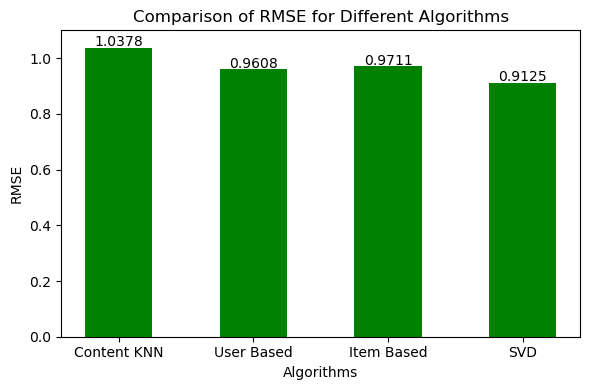

In [16]:
import matplotlib.pyplot as plt

# Dữ liệu về các thuật toán và giá trị RMSE
algorithms = ['Content KNN', 'User Based', 'Item Based', 'SVD']
rmse_values = [1.0378, 0.9608, 0.9711, 0.9125]

# Tạo biểu đồ cột
plt.figure(figsize=(6, 4))  # Kích thước nhỏ hơn
plt.bar(algorithms, rmse_values, color='green', width=0.5)  # Điều chỉnh độ rộng cột

# Thêm nhãn và tiêu đề
plt.xlabel('Algorithms')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Algorithms')
plt.ylim(0, 1.1)  # Thiết lập giới hạn trục y bắt đầu từ 0

# Hiển thị giá trị RMSE trên đầu các cột
for i, value in enumerate(rmse_values):
    plt.text(i, value + 0.005, f'{value:.4f}', ha='center')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


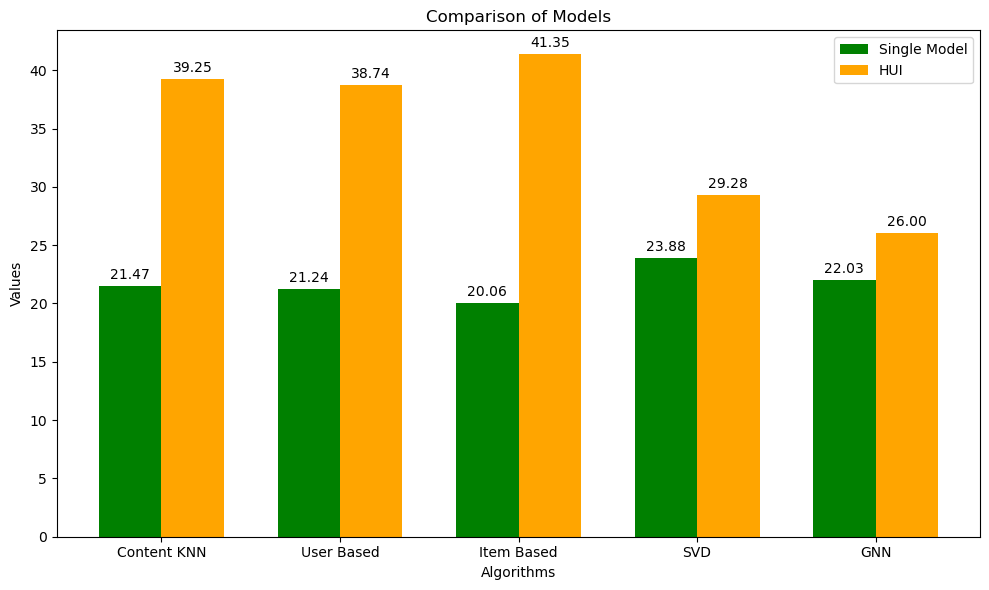

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Content KNN', 'User Based', 'Item Based', 'SVD', 'GNN']
single_model = [21.47,  21.24, 20.06, 23.88,22.03]
hui = [39.25, 38.74, 41.35, 29.28, 26]

# Plotting
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, single_model, width, label='Single Model', color='green')
bar2 = ax.bar(x + width/2, hui, width, label='HUI', color='orange')

# Add labels, title, and legend
ax.set_ylabel('Values')
ax.set_xlabel('Algorithms')
ax.set_title('Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adding value annotations
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


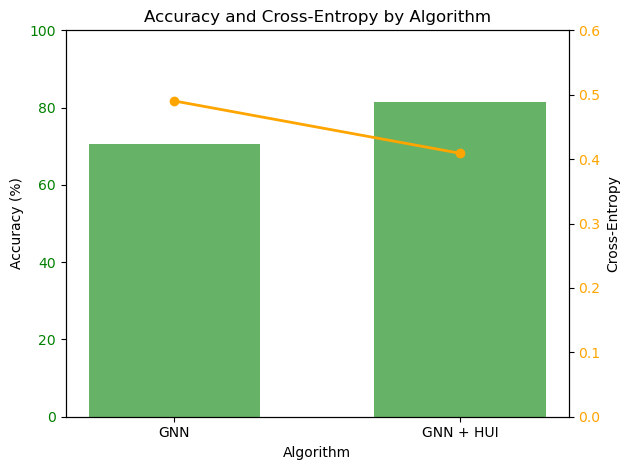

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
algorithms = ['GNN', 'GNN + HUI']
cross_entropy = [0.4903, 0.4091]  # Cross-Entropy values
accuracy = [70.68, 81.33]  # Accuracy values

# Bar width for smaller bars
bar_width = 0.6
index = np.arange(len(algorithms))

# Create figure and axis
fig, ax1 = plt.subplots()

# Plotting Accuracy as smaller bars (higher is better, so it should be on the left axis)
ax1.bar(index, accuracy, bar_width, color='green', alpha=0.6, label='Accuracy')
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Accuracy (%)', color='black')
ax1.set_ylim(0, 100)  # Setting range for Accuracy
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xticks(index)
ax1.set_xticklabels(algorithms)

# Create a second axis for plotting Cross-Entropy (lower is better, so it should be on the right axis)
ax2 = ax1.twinx()
ax2.plot(algorithms, cross_entropy, color='orange', marker='o', label='Cross-Entropy', linestyle='-', linewidth=2)
ax2.set_ylabel('Cross-Entropy', color='Black')
ax2.set_ylim(0, 0.6)  # Setting appropriate range for Cross-Entropy
ax2.tick_params(axis='y', labelcolor='orange')

# Title and display the plot
plt.title('Accuracy and Cross-Entropy by Algorithm')
fig.tight_layout()
plt.show()
